### Chemical Filtering Notebook  

This notebook contains all the code related to the **chemical filtering** step of the pipeline. Each cell includes a detailed description of its function.  

#### Key Functions:
1. **Applying Chemical Filters to Vendor Compounds:**  
   - Filters vendor compounds based on **Lipinski’s Rule of Five**, **Veber’s Rule**, **PAINS filtering**, and **ADMET properties**.  
   - Removes compounds that violate these drug-likeness rules.  
   - Saves the **filtered vendor compound list** to a CSV file.  

2. **Computing Dissimilarity from Known Antibiotics:**  
   - Compares vendor compounds to a set of **selected antibiotics** based on **Morgan fingerprints**.  
   - Uses **Tanimoto similarity** to identify compounds that are too similar to known drugs.  
   - Applies a **dissimilarity threshold** (e.g., 0.8) to retain only sufficiently novel compounds.  
   - Saves the **final dissimilarity-filtered compound list** to a CSV file.  


In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import FilterCatalog
from tqdm import tqdm  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.DataStructs.cDataStructs import ExplicitBitVect

In [ ]:
## HELPER FUNCTIONS ##

# Function to compute the Tanimoto dissimilarity matrix between vendor compounds 
def compute_tanimoto_dissimilarity_comp_vs_comp(fps):
    """Compute Tanimoto dissimilarity (1 - similarity) for a list of RDKit ExplicitBitVect fingerprints."""
    n = len(fps)
    dissim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):  # Compute only upper triangular and mirror it
            if fps[i] is not None and fps[j] is not None:
                sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
                dissim_matrix[i, j] = 1 - sim
                dissim_matrix[j, i] = 1 - sim  # Symmetric matrix

    return dissim_matrix

# Fingerprint parsing functions 
def parse_vendor_fingerprint(fp_string):
    """
    Convert a vendor-provided fingerprint (stored as a stringified list) into an RDKit fingerprint.

    Args:
        fp_string (str): Fingerprint string stored as a comma-separated list within brackets.

    Returns:
        rdkit.DataStructs.ExplicitBitVect or None: RDKit fingerprint object if conversion is successful, otherwise None.
    """
    try:
        # Convert string representation of the fingerprint into a list of integers
        bit_list = [int(bit) for bit in fp_string.strip("[]").split(",")]

        # Convert the bit list into an RDKit fingerprint object
        return DataStructs.CreateFromBitString("".join(map(str, bit_list)))
    except Exception:
        return None  # Return None if parsing fails
    
def parse_known_drug_fingerprint(fp_string):
    """
    Convert a known drug fingerprint (assumed to be preprocessed) into an RDKit fingerprint.

    Args:
        fp_string (str): Fingerprint stored as a string of bits.

    Returns:
        rdkit.DataStructs.ExplicitBitVect or None: RDKit fingerprint object if conversion is successful, otherwise None.
    """
    try:
        return DataStructs.CreateFromBitString(fp_string)  # Convert directly from string format
    except Exception:
        return None  # Return None if parsing fails

In [ ]:
## APPLIES THE WELL ESTABLISHED FILTERS CHEMICAL FILTERS LIPINSKI, VEBER AND PAINS ##

def is_pains(smiles, catalog):
    """
    Check if a molecule matches a PAINS (Pan-Assay Interference Compounds) filter.

    Args:
        smiles (str): SMILES string representation of the molecule.
        catalog (rdkit.Chem.FilterCatalog.FilterCatalog): PAINS filter catalog.

    Returns:
        bool: True if the molecule matches a PAINS filter, otherwise False.
    """
    mol = Chem.MolFromSmiles(smiles)  # Convert SMILES string to RDKit molecule object
    if mol:
        entry = catalog.GetFirstMatch(mol)  # Check for a match in the PAINS catalog
        return entry is not None  # Returns True if a PAINS match is found
    return False  # Returns False if the molecule is invalid or no match is found


def apply_filters(df):
    """
    Apply Lipinski, Veber and PAINS filtering to a dataset of molecules.

    Filters applied:
    - Lipinski’s Rule of Five (MW, ClogP, HBD)
    - Veber’s Rule (TPSA, RotBonds)
    - PAINS filtering (Removes molecules flagged as PAINS)
    
    Args:
        df (pd.DataFrame): DataFrame containing molecular properties, including:
            - "SMILES": Molecular structure as SMILES string.
            - "MW": Molecular weight.
            - "ClogP": Calculated octanol-water partition coefficient.
            - "HBD": Hydrogen bond donors.
            - "TPSA": Topological polar surface area.
            - "RotBonds": Number of rotatable bonds.

    Returns:
        pd.DataFrame: Filtered DataFrame with only molecules passing all criteria.
    """

    # Initialize the PAINS filter catalog
    params = FilterCatalog.FilterCatalogParams()
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_C)
    catalog = FilterCatalog.FilterCatalog(params)

    # Apply PAINS filtering: Checks if each molecule is flagged as PAINS
    df['PAINS'] = df['SMILES'].apply(lambda x: is_pains(x, catalog))

    # Apply Lipinski’s and Veber’s rules along with PAINS filtering
    filtered_df = df[
        (df["MW"] >= 150) & (df["MW"] <= 500) &  # Lipinski: Molecular weight (MW) within range
        (df["ClogP"] >= -0.5) & (df["ClogP"] <= 5) &  # Lipinski: LogP within range
        (df["HBD"] <= 5) &  # Lipinski: Max hydrogen bond donors
        (df["TPSA"] <= 140) &  # Veber: Max TPSA for permeability
        (df["RotBonds"] <= 10) &  # Veber: Max rotatable bonds
        (df["PAINS"] == False)  # Exclude molecules flagged as PAINS
    ]

    return filtered_df  # Return the DataFrame containing only filtered compounds

# Define the input file containing vendor compounds with molecular fingerprints
input_file_without_csv = "filtered_compounds_diss_0.8_everything"  

# Load the vendor compound dataset
df = pd.read_csv(f"{input_file_without_csv}.csv")

# Apply the defined chemical filters (Lipinski, Veber, PAINS, ADMET)
filtered_df = apply_filters(df)

# Define the output file path for the filtered compound list
output_file = f"{input_file_without_csv}_chemically_filtered.csv"

# Save the filtered vendor compound list to a CSV file
filtered_df.to_csv(output_file, index=False)

print(f"Filtered vendor list saved to {output_file}")


In [ ]:
## FILTERS OUT THE LOWER RANKED VENDOR COMPOUNDS FROM SIMILAR PAIRS ##

def dissimilarity_computation_antib_vs_comp(df, known_drugs_df, threshold, selected):
    """
    Compute the molecular dissimilarity between vendor compounds and a set of known antibiotics.

    The function:
    - Parses vendor compound fingerprints.
    - Parses known drug fingerprints.
    - Computes the Tanimoto similarity between each vendor compound and known drug.
    - Filters out compounds that are too similar to known drugs based on a defined dissimilarity threshold.

    Args:
        df (pd.DataFrame): DataFrame containing vendor compound fingerprints in the "Morgan_Fingerprint" column.
        known_drugs_df (pd.DataFrame): DataFrame containing known drug fingerprints in the "morgan_1024_fp" column.
        threshold (float): Minimum dissimilarity required for a compound to pass the filter (1 - max similarity).
        selected (bool): "True" if only the 10 antibiotics that are known to work well against K. Pneumoniae should be accounted for 
                         "False" if all known antibiotics from DRIAMS should be compared to the candidates 

    Returns:
        pd.DataFrame: A filtered DataFrame containing only vendor compounds that pass the dissimilarity threshold.
    """
    if selected == True:
        # Define the known antibiotics to be used for similarity comparison
        selected_drugs = [
            "Ampicillin", "Amoxicillin", "Piperacillin", "Cefuroxime", "Cefepime",
            "Ceftriaxone", "Meropenem", "Gentamicin", "Cotrimoxazol", "Ciprofloxacin"
        ]
        
        # Filter known drugs to include only those from the selected list
        known_drugs_df = known_drugs_df[known_drugs_df["drug"].isin(selected_drugs)].copy()

    # Parse fingerprints for vendor compounds using a progress bar
    tqdm.pandas(desc="Parsing vendor fingerprints")
    df['parsed_fp'] = df['Morgan_Fingerprint'].progress_apply(parse_vendor_fingerprint)

    # Parse fingerprints for known drugs using a progress bar
    tqdm.pandas(desc="Parsing known drug fingerprints")
    known_drugs_df['parsed_fp'] = known_drugs_df['morgan_1024_fp'].progress_apply(parse_known_drug_fingerprint)

    # Remove rows with missing fingerprints (failed conversions)
    df = df.dropna(subset=['parsed_fp'])
    known_drugs_df = known_drugs_df.dropna(subset=['parsed_fp'])

    print("Computing dissimilarity...")

    filtered_results = []  # Store filtered vendor compounds

    # Iterate through each vendor compound and compute similarity with known drugs
    for _, compound_row in tqdm(df.iterrows(), total=len(df), desc="Filtering based on dissimilarity"):
        compound_fp = compound_row["parsed_fp"]

        # Compute the Tanimoto similarity between the vendor compound and all known drugs
        similarities = DataStructs.BulkTanimotoSimilarity(compound_fp, list(known_drugs_df["parsed_fp"]))

        # Compute the minimum dissimilarity (1 - max similarity)
        min_dissimilarity = 1 - max(similarities)

        # Keep the compound if it meets the dissimilarity threshold
        if min_dissimilarity >= threshold:
            filtered_results.append(compound_row)

    # Return a new DataFrame with only the filtered compounds
    return pd.DataFrame(filtered_results)

# Set the dissimilarity threshold (compounds must be at least this different from known drugs)
threshold = 0.6  
selected = False

# Define input and output file paths
input_path_without_csv = "rankings/combined_ranking_top200_raw_morgan_log_diss_0.6_comp"
input_file = f"{input_path_without_csv}.csv"  # Filtered compounds after chemical rules
output_file = f"{input_path_without_csv}_diss_antib_{threshold}_{"everything" if not selected else "10"}.csv"  # Output file for final dissimilarity-filtered list
known_drugs_file = "processed_data/drug_fingerprints.csv"  # Known drug fingerprints

# Load vendor compounds and known drug fingerprint datasets
df = pd.read_csv(input_file)
known_drugs_df = pd.read_csv(known_drugs_file)

# Apply the dissimilarity filtering process
filtered_df = dissimilarity_computation_antib_vs_comp(df, known_drugs_df, threshold, selected)

# Save the filtered compounds that pass the dissimilarity threshold
filtered_df.to_csv(output_file, index=False)

print(f"Filtered dataset saved to {output_file} with {len(filtered_df)} compounds.")


In [ ]:
## FILTERS OUT VENDOR COMPOUNDS SIMILAR TO KNOWN ANTIBIOTICS ##

# File path and threshold
threshold = 0.6
input_file_without_csv = "rankings/combined_ranking_top200_raw_morgan_log" 
csv_file = f"{input_file_without_csv}.csv" 
output_csv = f"{input_file_without_csv}_diss_{threshold}_comp.csv"  


# Ranking column (lower values mean better ranking)
rank_col = "Log Sum Probability Ranking"

# Function to filter out vendor lower-ranked compounds in similar pairs
def filter_compounds_by_dissimilarity_to_each_other(df, dissim_matrix, rank_col, threshold=0.6):
    """Filter lower-ranked vendor compounds in pairs with dissimilarity below the threshold."""
    if rank_col not in df.columns:
        raise ValueError(f"The dataframe must have a '{rank_col}' column to perform filtering.")

    to_remove = set()
    n = len(df)

    for i in range(n):
        for j in range(i + 1, n):  # Avoid duplicate checks
            if dissim_matrix[i, j] < threshold:  # Threshold-based filtering
                # Compare rankings (lower values mean better ranking)
                if df.loc[i, rank_col] > df.loc[j, rank_col]:  
                    to_remove.add(i)  # Remove the lower-ranked compound
                else:
                    to_remove.add(j)

    # Filter dataframe and sort by ranking
    filtered_df = df.drop(index=to_remove).reset_index(drop=True)
    filtered_df = filtered_df.sort_values(by=rank_col).reset_index(drop=True)

    return filtered_df

# Load CSV file
df = pd.read_csv(csv_file)

# Keep only the first 40 rows 
df = df.iloc[:40]

# Convert stored fingerprints to RDKit ExplicitBitVect
df["Fingerprint"] = df["Morgan_Fingerprint"].apply(parse_vendor_fingerprint)

# Compute dissimilarity matrix
dissimilarity_matrix = compute_tanimoto_dissimilarity_comp_vs_comp(df["Fingerprint"].tolist())

# Filter compounds
filtered_df = filter_compounds_by_dissimilarity_to_each_other(df, dissimilarity_matrix, rank_col, threshold)

# Save final results to CSV
filtered_df.to_csv(output_csv, index=False)

print(f"Filtered results saved to {output_csv}")

Filtered results saved to rankings/combined_ranking_top200_raw_morgan_log_diss_0.6_comp2.csv


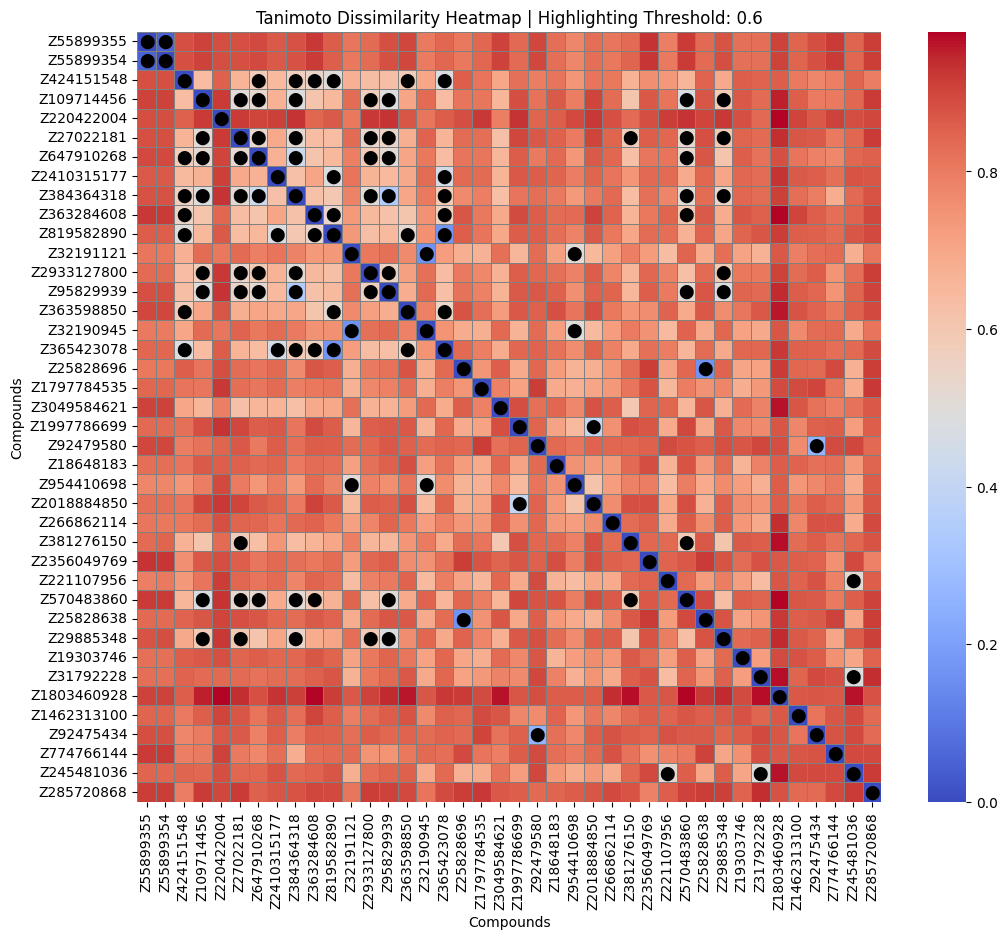

In [ ]:
## PLOTS THE TANIMOTO DISSIMILARITY HEATMAP COMPARING VENDOR COMPOUNDS TO ONE ANOTHER ##

# File path
csv_file = "rankings/combined_ranking_top200_raw_morgan_log.csv"  

# Function to plot the heatmap with threshold highlighting
def plot_dissimilarity_heatmap(dissim_matrix, labels, threshold=0.8):
    """Plot heatmap of Tanimoto dissimilarity with clear highlights for values below threshold."""
    plt.figure(figsize=(12, 10))

    # Create the heatmap
    ax = sns.heatmap(
        dissim_matrix, 
        xticklabels=labels, 
        yticklabels=labels, 
        cmap="coolwarm", 
        linewidths=0.5, 
        linecolor="gray", 
        cbar=True
    )

    # Highlight pairs with dissimilarity < threshold
    for i in range(len(labels)):
        for j in range(len(labels)):
            if dissim_matrix[i, j] < threshold:
                ax.text(j + 0.5, i + 0.5, "⬤", ha='center', va='center', 
                        color='black', fontsize=10)

    # Rotate labels for better readability
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    # Dynamic title with threshold info
    plt.title(f"Tanimoto Dissimilarity Heatmap | Highlighting Threshold: {threshold}")

    plt.xlabel("Compounds")
    plt.ylabel("Compounds")
    plt.show()

# Load CSV file
df = pd.read_csv(csv_file)

# Keep only the first 40 rows for visualization
df = df.iloc[:40]

# Convert stored fingerprints to RDKit ExplicitBitVect
df["Fingerprint"] = df["Morgan_Fingerprint"].apply(parse_vendor_fingerprint)

# Compute dissimilarity matrix
dissimilarity_matrix = compute_tanimoto_dissimilarity_comp_vs_comp(df["Fingerprint"].tolist())

# Plot heatmap with threshold-based highlighting
plot_dissimilarity_heatmap(dissimilarity_matrix, df["Name"].tolist(), threshold=0.6)


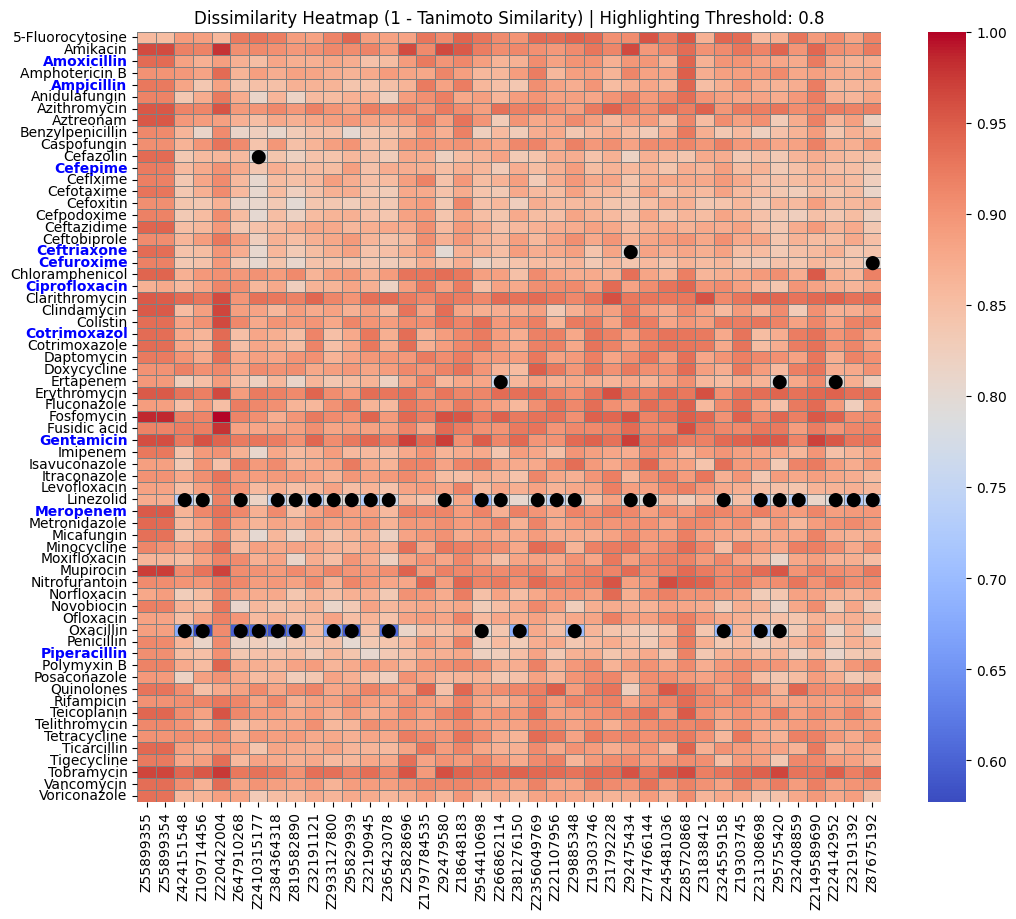

In [ ]:
## PLOTS THE TANIMOTO DISSIMILARITY HEATMAP COMPARING VENDOR COMPOUNDS TO KNOWN ANTIBIOTICS ##

# File paths
compounds_csv = "rankings/combined_ranking_top100_raw_morgan_log.csv" 
antibiotics_csv = "processed_data/drug_fingerprints.csv"  

# Function to load fingerprints from CSV
def load_fingerprints_from_csv(filepath, fingerprint_column, parser):
    df = pd.read_csv(filepath)
    df["Fingerprint"] = df[fingerprint_column].apply(parser)
    df = df.dropna(subset=["Fingerprint"])  # Remove rows where parsing failed
    return df

# Function to compute similarity matrix between known antibiotics and vendor compounds 
def compute_similarity_matrix_antib_vs_comp(compound_df, antibiotic_df):
    similarity_matrix = np.zeros((len(antibiotic_df), len(compound_df)))

    for i, ant_fp in enumerate(antibiotic_df["Fingerprint"]):
        for j, cmp_fp in enumerate(compound_df["Fingerprint"]):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(ant_fp, cmp_fp)

    return similarity_matrix, compound_df["Name"].tolist(), antibiotic_df["drug"].tolist()

# Load compound and antibiotic fingerprints
compound_df = load_fingerprints_from_csv(compounds_csv, "Morgan_Fingerprint", parse_vendor_fingerprint)
antibiotic_df = load_fingerprints_from_csv(antibiotics_csv, "morgan_1024_fp", parse_known_drug_fingerprint)

# Compute the similarity matrix
similarity_matrix, compound_names, antibiotic_names = compute_similarity_matrix_antib_vs_comp(compound_df, antibiotic_df)

# Convert similarity to dissimilarity (1 - Tanimoto similarity)
dissimilarity_matrix = 1 - similarity_matrix

# Define antibiotics to highlight
highlighted_drugs = {"Ampicillin", "Amoxicillin", "Piperacillin", "Cefuroxime", 
                     "Cefepime", "Ceftriaxone", "Meropenem", "Gentamicin", 
                     "Cotrimoxazol", "Ciprofloxacin"}

# Define the threshold for highlighting
threshold = 0.8

# Create the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(dissimilarity_matrix, cmap="coolwarm", xticklabels=compound_names, 
                 yticklabels=antibiotic_names, linewidths=0.5, linecolor='gray')

# Highlight values with dissimilarity < threshold
for i in range(len(antibiotic_names)):
    for j in range(len(compound_names)):
        if dissimilarity_matrix[i, j] < threshold:
            ax.text(j + 0.5, i + 0.5, "⬤", ha='center', va='center', 
                    color='black', fontsize=10)

# Make specified antibiotics bold and blue
for i, drug in enumerate(antibiotic_names):
    if drug in highlighted_drugs:
        ax.get_yticklabels()[i].set_fontweight("bold")
        ax.get_yticklabels()[i].set_color("blue")

# Rotate labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Dynamic title with threshold information
plt.title(f"Dissimilarity Heatmap (1 - Tanimoto Similarity) | Highlighting Threshold: {threshold}")

plt.show()